In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pickle
# import torch

from collections import Counter
from scipy import stats, cluster
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from utils.conformal_utils import *

In [25]:
def quantile_embedding(samples, q=[0.5, 0.6, 0.7, 0.8, 0.9]):
    '''
    Computes the q-quantiles of samples and returns the vector of quantiles
    '''
    return np.quantile(samples, q)

def embed_all_classes(scores_all, labels, q=[0.5, 0.6, 0.7, 0.8, 0.9]):
    '''
    Input:
        - scores_all: num_instances x num_classes array where 
        cal_class_scores[i,j] = score of class j for instance i
        - labels: num_instances-length array of true class labels
        
    Output: num_classes x len(q) array where ith row is the embeddings of class i
    '''
    num_classes = scores_all.shape[1]
    
    embeddings = np.zeros((num_classes, len(q)))
    for i in range(num_classes):
        class_i_scores = scores_all[labels==i,i]
        embeddings[i,:] = quantile_embedding(class_i_scores, q=q)
    
    return embeddings
    

def _clustered_conformal(totalcal_scores, totalcal_labels,
                        alpha,
                        n_clustering, num_clusters,
                        val_scores=None, val_labels=None):
    '''
    Helper for clustered_conformal() that assumes clustering_frac
    and num_clusters are given. See clustered_conformal() for documentation.
    
    '''
    
    num_classes = totalcal_scores.shape[1]
    
    # 0) Split data 
    scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                               totalcal_labels, 
                                                               n_clustering, 
                                                               num_classes=num_classes, 
                                                               seed=0)
    
    # 1) Compute embedding for each class
    embeddings = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9])
        
    # 2) Cluster classes
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(embeddings)
    cluster_assignments = kmeans.labels_  
    
    # Print cluster sizes
    print(f'Cluster sizes:', [x[1] for x in Counter(cluster_assignments).most_common()])
    
    # 3) Compute qhats for each cluster
    cal_scores_all = scores2_all
    cal_labels = labels2
    qhats = compute_cluster_specific_qhats(cluster_assignments, 
               cal_scores_all, cal_labels, 
               alpha=alpha, 
               default_qhat=np.inf)
    
    # 4) [Optionally] Apply to val set. Evaluate class coverage gap and set size 
    if (val_scores is not None) and (val_labels is not None):
        preds = create_cb_prediction_sets(val_scores_all, qhats)
        class_specific_cov = compute_class_specific_coverage(val_labels, preds)

        class_cov_gap = np.sum(np.abs(class_specific_cov - (1-alpha)))

        curr_set_sizes = [len(x) for x in preds]
        set_size_metrics = {'mean': np.mean(curr_set_sizes), '[.25, .5, .75, .9] quantiles': np.quantile(curr_set_sizes, [.25, .5, .75, .9])}
        
        return qhats, preds, class_cov_gap, set_size_metrics
    else:
        return qhats
            


def clustered_conformal(totalcal_scores, totalcal_labels,
                        alpha,
                        tune_parameters=True,
                        n_clustering=None, num_clusters=None,
                        val_scores=None, val_labels=None):
    '''
    Use totalcal_scores and total_labels to compute conformal quantiles for each
    class using the clustered conformal procedure. Optionally evaluates 
    performance on val_scores and val_labels
    
    Inputs:
         - totalcal_scores: num_instances x num_classes array where 
           cal_class_scores[i,j] = score of class j for instance i
         - totalcal_labels: num_instances-length array of true class labels (0-indexed classes)
         - alpha: number between 0 and 1 that determines coverage level.
         Coverage level will be 1-alpha.
         - tune_parameters: If True, ignore n_clustering and num_clusters
         and tune the parameters using the elbow method. If False, use n_clustering
         and num_clusters
         - n_clustering: Number of points per class to use for clustering step. The remaining
         points are used for the conformal calibration step.
         - num_clusters: Number of clusters to group classes into
         - val_scores: num_val_instances x num_classes array, or None. If not None, 
         the class coverage gap and average set sizes will be computed on val_scores
         and val_labels.
         - val_labels: num_val_instances-length array of true class labels, or None. 
         If not None, the class coverage gap and average set sizes will be computed 
         on val_scores and val_labels.
         
    Outputs:
        - qhats: num_classes-length array where qhats[i] = conformal quantial estimate for class i
        - [Optionally, if val_scores and val_labels are not None] 
            - val_preds: clustered conformal predictions on val_scores
            - val_class_coverage_gap: Class coverage gap, compute on val_scores and val_labels
            - val_set_size_metrics: Dict containing set size metrics, compute on val_scores and val_labels
    '''
    
    if not tune_parameters:
        assert n_clustering is not None and num_clusters is not None, \
        'When tune_parameters=False, clustering_frac and num_clusters must be defined'
        
        return _clustered_conformal(totalcal_scores, totalcal_labels,
                                    alpha,
                                    n_clustering, num_clusters,
                                    val_scores=val_scores, val_labels=val_labels)
    else:
        
        # List of possible amounts of data to use for clustering
        # Try [.3, .5, .7, .9]-fractions of the rarest class in the calibration dataset
        rarest_class_ct = Counter(totalcal_labels).most_common()[-1][1]
        n_clustering_list = (np.array([.3, .5, .7, .9]) * rarest_class_ct).astype(np.int32)
        
        # List of possible numbers of clusters 
        num_clusters_list = np.arange(1,21)
        
        best_k = [] # Best k for each n_clustering
        best_k_score = [] # Inertia for each best k
        
        for n_clustering in n_clustering_list:
            
            # 0) Split data 
            scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                               totalcal_labels, 
                                                               n_clustering, 
                                                               num_classes=num_classes, 
                                                               seed=0)
    
            # 1) Compute embedding for each class
            embeddings = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9])
         
            # 2) Do k-means with different k's
            model = KMeans(n_init=10)
            visualizer = KElbowVisualizer(model, k=num_clusters_list, timings=False)
            visualizer.fit(embeddings)        # Fit data to visualizer
            
            # Optional: show elbow plot
            visualizer.show()        
            
            best_k.append(visualizer.elbow_value_)
            best_k_score.append(visualizer.elbow_score_)
            
        # Select n_clustering with lowest inertia at the elbow
        min_idx = np.argmin(best_k_score)
        best_n_clustering = n_clustering_list[min_idx]
        best_num_clusters = best_k[min_idx]
        print('Best n_clustering:', best_n_clustering)
        print('Best num_clusters:', best_num_clusters)
        
        return _clustered_conformal(totalcal_scores, totalcal_labels,
                                    alpha,
                                    best_n_clustering, best_num_clusters,
                                    val_scores=val_scores, val_labels=val_labels)
            

## Test

In [6]:
alpha = .1
n_totalcal = 10 # Total number of calibration points (= # clustering examples + # conformal calibration examples)


# Enron - BERT
softmax_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_softmax_bert.npy"
labels_path = "../class-conditional-conformal-datasets/notebooks/.cache/email_labels_bert.npy"

In [7]:
## 1. Get data ============================
print('Loading softmax scores and labels...')

softmax_scores = np.load(softmax_path)
labels = np.load(labels_path)

num_classes = labels.max() + 1

Loading softmax scores and labels...


In [26]:
# for score_function in ['softmax', 'APS', 'RAPS']:
n_clustering_list = (np.array([.3, .5, .7, .9]) * n_totalcal).astype(np.int32)


for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')


    print('Splitting data...')
    # Split into clustering+calibration data and validation data
    totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)

    for n_clustering in n_clustering_list:
            
        # 0) Split data 
        scores1_all, labels1, scores2_all, labels2 = split_X_and_y(totalcal_scores_all, 
                                                           totalcal_labels, 
                                                           n_clustering, 
                                                           num_classes=num_classes, 
                                                           seed=0)

        # 1) Compute embedding for each class
        embeddings = embed_all_classes(scores1_all, labels1, q=[0.5, 0.6, 0.7, 0.8, 0.9])

        # 2) Do k-means with different k's
        for num_clusters in np.arange(1,13):
            kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10).fit(embeddings)
            cluster_assignments = kmeans.labels_  

            # Print cluster sizes
            print(f'[n_clustering={n_clustering}, num_clusters={num_clusters}] Cluster sizes:', [x[1] for x in Counter(cluster_assignments).most_common()])


====== score_function=softmax ======
Computing conformal score...
Splitting data...
[n_clustering=3, num_clusters=1] Cluster sizes: [109]
[n_clustering=3, num_clusters=2] Cluster sizes: [87, 22]
[n_clustering=3, num_clusters=3] Cluster sizes: [74, 28, 7]
[n_clustering=3, num_clusters=4] Cluster sizes: [62, 26, 17, 4]
[n_clustering=3, num_clusters=5] Cluster sizes: [61, 26, 14, 6, 2]
[n_clustering=3, num_clusters=6] Cluster sizes: [59, 22, 17, 5, 4, 2]
[n_clustering=3, num_clusters=7] Cluster sizes: [59, 16, 13, 13, 4, 2, 2]
[n_clustering=3, num_clusters=8] Cluster sizes: [59, 16, 13, 13, 3, 2, 2, 1]
[n_clustering=3, num_clusters=9] Cluster sizes: [59, 16, 12, 11, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=10] Cluster sizes: [36, 23, 16, 12, 11, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=11] Cluster sizes: [31, 28, 16, 11, 8, 4, 3, 3, 2, 2, 1]
[n_clustering=3, num_clusters=12] Cluster sizes: [36, 23, 15, 12, 7, 3, 3, 3, 2, 2, 2, 1]
[n_clustering=5, num_clusters=1] Cluster sizes: [10

====== score_function=softmax ======
Computing conformal score...
Splitting data...


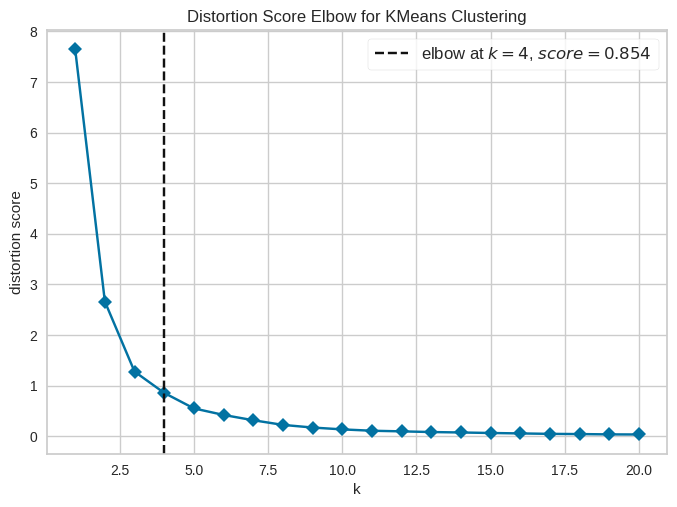

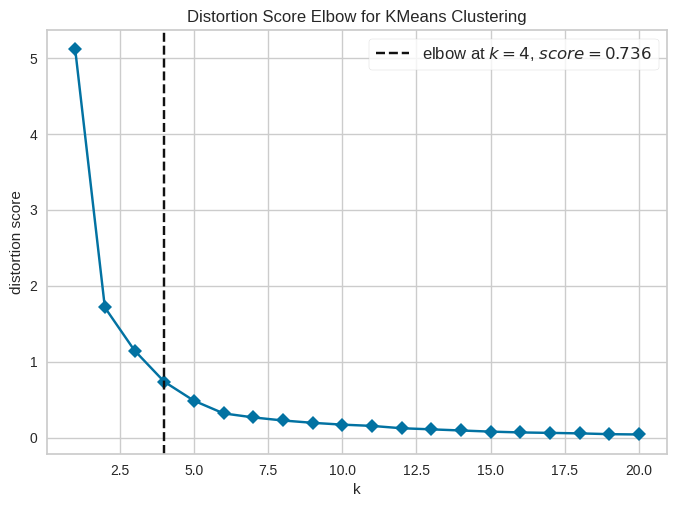

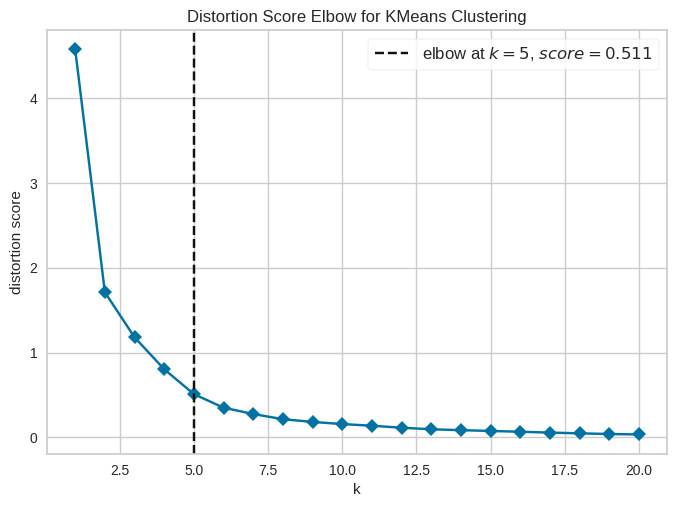

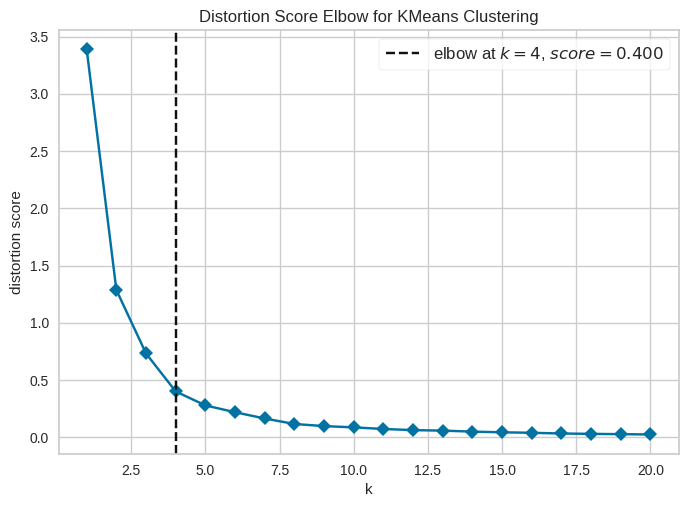

Best n_clustering: 9
Best num_clusters: 4
Cluster sizes: [(0, 88), (1, 17), (3, 3), (2, 1)]
[Clustered conformal] Class coverage gap: 6.627446847142502
[Clustered conformal] Set size metrics {'mean': 63.17446126491617, '[.25, .5, .75, .9] quantiles': array([55., 68., 76., 82.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...


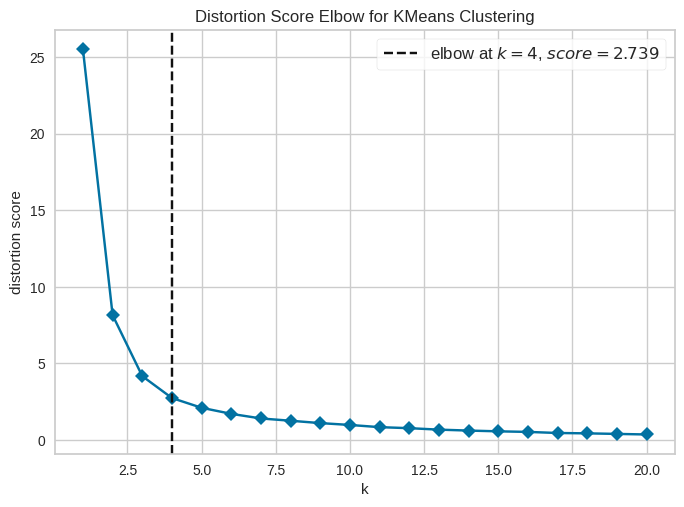

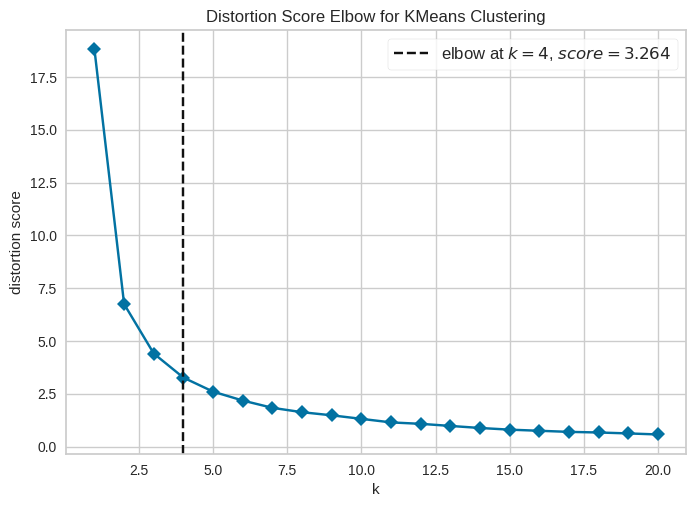

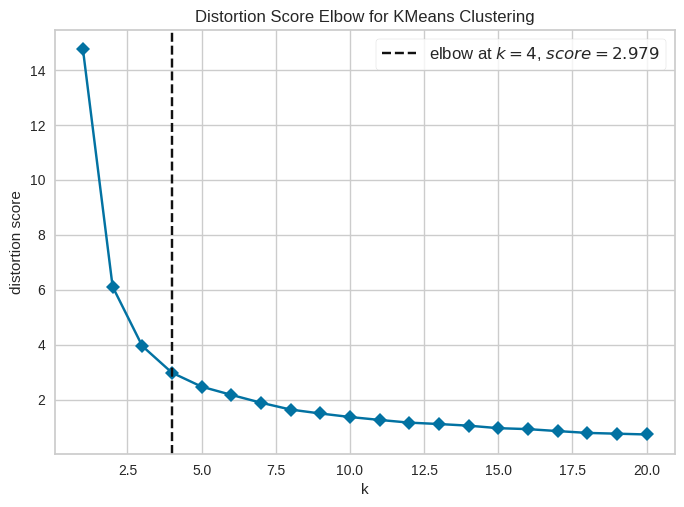

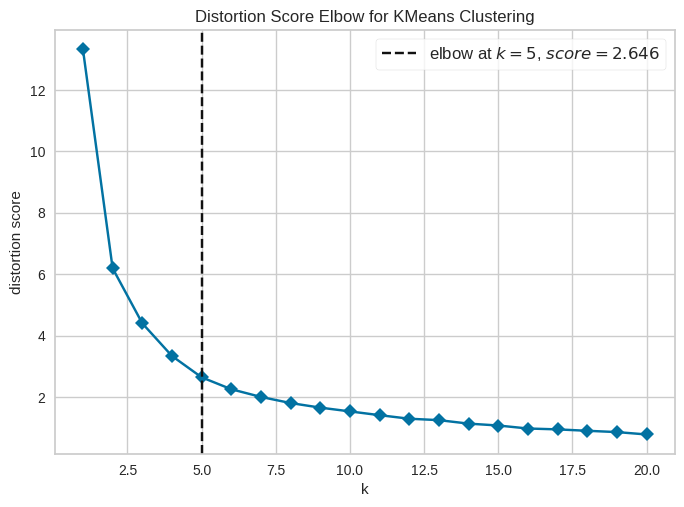

Best n_clustering: 9
Best num_clusters: 5
Cluster sizes: [(4, 30), (2, 23), (0, 23), (1, 18), (3, 15)]
[Clustered conformal] Class coverage gap: 6.701743518999062
[Clustered conformal] Set size metrics {'mean': 66.72654921553159, '[.25, .5, .75, .9] quantiles': array([62., 71., 76., 80.])}


In [16]:
# for score_function in ['softmax', 'APS', 'RAPS']:
for score_function in ['softmax', 'APS']:
    
    print(f'====== score_function={score_function} ======')
    
    print('Computing conformal score...')
    if score_function == 'softmax':
        scores_all = 1 - softmax_scores
    elif score_function == 'APS':
        scores_all = get_APS_scores_all(softmax_scores, randomize=True)
    elif score_function == 'RAPS': 
        
        # RAPS hyperparameters (currently using ImageNet defaults)
        lmbda = .01 
        kreg = 5
        
        scores_all = get_RAPS_scores_all(softmax_scores, lmbda, kreg, randomize=True)
    else:
        raise Exception('Undefined score function')


    print('Splitting data...')
    # Split into clustering+calibration data and validation data
    totalcal_scores_all, totalcal_labels, val_scores_all, val_labels = split_X_and_y(scores_all, labels, n_totalcal, num_classes=num_classes, seed=0)


    qhats, preds, class_cov_gap, set_size_metrics = clustered_conformal(totalcal_scores_all, totalcal_labels,
                                                                        alpha,
                                                                        tune_parameters=True,
                                                                        n_clustering=None, num_clusters=None,
                                                                        val_scores=val_scores_all, val_labels=val_labels)
    print('[Clustered conformal] Class coverage gap:', class_cov_gap)
    print('[Clustered conformal] Set size metrics', set_size_metrics)

In [ ]:
====== SETTINGS =====
alpha=0.1
n_totalcal=10
=====================
Loading softmax scores and labels...
====== score_function=softmax ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.98%
Marginal coverage of NaiveCC: 90.21%
[Vanilla] Average class-coverage gap: 1.950
[NaiveCC] Average class-coverage gap: 6.689
[Vanilla] set size metrics: {'mean': 36.35996393824424, '[.25, .5, .75, .9] quantiles': array([28., 39., 46., 52.])}
[NaiveCC] set size metrics: {'mean': 47.23285376206754, '[.25, .5, .75, .9] quantiles': array([41., 51., 57., 62.])}
====== score_function=APS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 89.78%
Marginal coverage of NaiveCC: 89.81%
[Vanilla] Average class-coverage gap: 2.026
[NaiveCC] Average class-coverage gap: 6.570
[Vanilla] set size metrics: {'mean': 37.01091118540501, '[.25, .5, .75, .9] quantiles': array([30., 40., 48., 53.])}
[NaiveCC] set size metrics: {'mean': 48.94149981843908, '[.25, .5, .75, .9] quantiles': array([43., 52., 58., 63.])}
====== score_function=RAPS ======
Computing conformal score...
Splitting data...
Evaluating baselines...
Marginal coverage of Vanilla: 90.28%
Marginal coverage of NaiveCC: 90.08%
[Vanilla] Average class-coverage gap: 1.925
[NaiveCC] Average class-coverage gap: 6.474
[Vanilla] set size metrics: {'mean': 42.515172232448066, '[.25, .5, .75, .9] quantiles': array([40., 43., 46., 48.])}
[NaiveCC] set size metrics: {'mean': 52.44974518863554, '[.25, .5, .75, .9] quantiles': array([50., 53., 56., 58.])}

### TODO: change clustering_frac to num_conformal. I think this will work better for imbalanced datasets. Hmm... or maybe not? If you have 5 examples in class k, maybe it is better to spend those data points on clustering them with other classes with more points (rather than trying to directly estimate the quantile on the 5 points)

okay so maybe for now, stick with num_clustering? Won't be too hard to change later on